<a href="https://colab.research.google.com/github/cdurakci/nnet_ts_forecast_demos/blob/main/neuralforecast_deneme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Gerekli Olan Python Paketlerini Colab Ortamına Yükle
!pip install neuralforecast
!pip install StatsForecast

In [3]:
import pandas as pd #CSV Veri Okutmak ve Veri manipülasyonu için R'daki DataFrame'in karşılığı
import numpy as np #numpy vektörel matrissel numerik veri işlemek için

from neuralforecast import NeuralForecast # Ana Paketimiz
from neuralforecast.models import LSTM, NHITS, RNN, NBEATS # Kullanmak istediğimiz NNet Model Mimarileri
from neuralforecast.losses.pytorch import MQLoss, MAE, DistributionLoss  #Loss Function

from statsforecast import StatsForecast # Plot Fonksiyonu'nun olduğu paket

path = 'KRDMD_data.csv'#'usdtry.csv' #Bu dosayayı yandaki dosya yükleme alanına sürükleyip bırakıyoruz
data = pd.read_csv(path, parse_dates=['Date'])
data.head() # verimiz klasick OHLC ve Volume Adjusted formatında

,Date,Id,Open,High,Low,Close,Volume,Adjusted
0,2017-01-02,0,1.15,1.15,1.14,1.15,8952995,1.15
1,2017-01-03,0,1.15,1.16,1.13,1.14,42792000,1.14
2,2017-01-04,0,1.14,1.14,1.11,1.12,31016884,1.12
3,2017-01-05,0,1.12,1.14,1.11,1.13,58083932,1.13
4,2017-01-06,0,1.13,1.14,1.13,1.14,7313235,1.14


In [4]:
data = data[['Date','Id','Close']] #Verideki bu Üç Kolonu seçiyoruz

In [5]:
# Kullandığımız NeuralForecast paketinin kendi kriteri, veriyi bu kolon isimleri ile istiyor tarih ds, target y, bir de unique_id olacak
#o yüzden yeniden isimlendiriyoruz
data = data.rename(columns={'Date': 'ds', 'Close': 'y', 'Id': 'unique_id'})

In [6]:
data.head() # Veriyi Kontrol Edelim

,ds,unique_id,y
0,2017-01-02,0,1.15
1,2017-01-03,0,1.14
2,2017-01-04,0,1.12
3,2017-01-05,0,1.13
4,2017-01-06,0,1.14


In [7]:
train = data.loc[data['ds'] <= '2022-12-31'] # 2023 öncesi veriyi Training Data olarak seçiyoruz
valid = data.loc[(data['ds'] > '2023-01-01') & (data['ds'] < '2024-02-06')] #2023 Sonrasını Holdout set, Out-of-Sample için tutuyoruz

h = valid['ds'].nunique() # Ne kadar adet veriyi valiation için ayırdık onu saydırıyoruz
h # sonra bunu parametre olarak kullanıp bu sayı kadar ilerisi için tahmin yaptırıcaz

270

In [8]:
train.head()

,ds,unique_id,y
0,2017-01-02,0,1.15
1,2017-01-03,0,1.14
2,2017-01-04,0,1.12
3,2017-01-05,0,1.13
4,2017-01-06,0,1.14


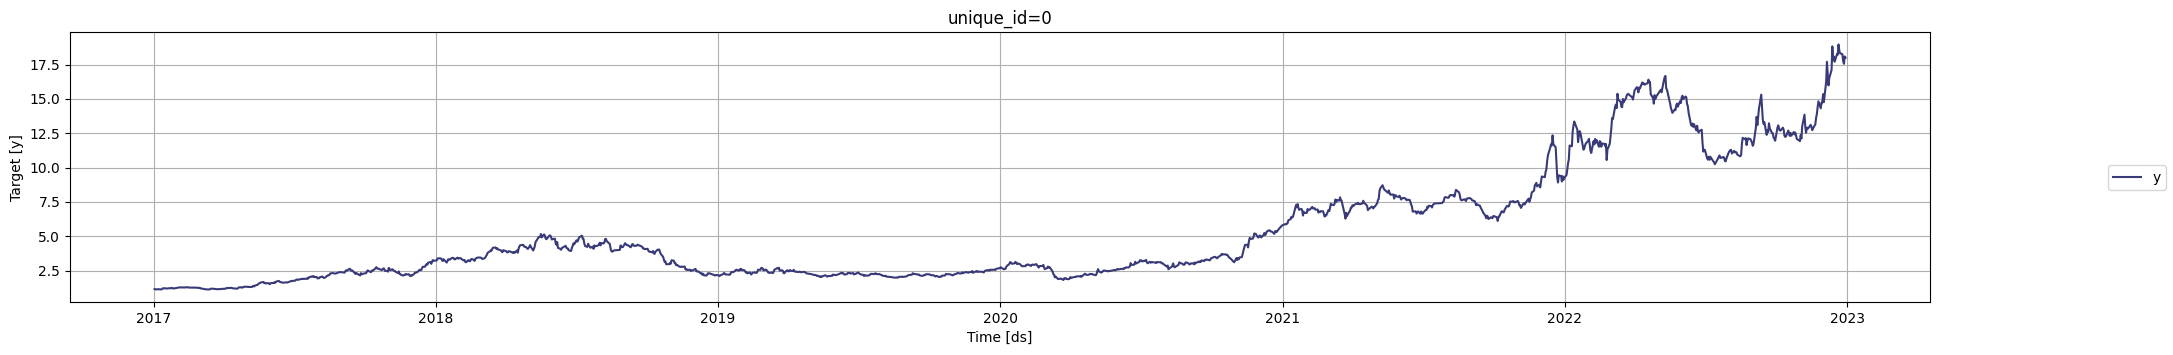

In [9]:
StatsForecast.plot(train, engine='matplotlib') #Çizdirelim

In [10]:
horizon = h

# LSTM ve NHITS modellerini deneyelim

models = [LSTM(h=horizon,                    # Forecast horizon
               input_size = 2 * horizon,
               max_steps=500,                # Number of steps to train
               scaler_type='standard',       # Type of scaler to normalize data
               encoder_hidden_size=64,       # Defines the size of the hidden state of the LSTM
               decoder_hidden_size=64),     # Defines the number of hidden units of each layer of the MLP decoder

          NHITS(h=horizon,                   # Forecast horizon
                input_size=2 * horizon,      # Length of input sequence
                max_steps=100,               # Number of steps to train
                n_freq_downsample=[2, 1, 1]) # Downsampling factors for each stack output
          ]
nf = NeuralForecast(models=models, freq='D')
nf.fit(df=train)


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [11]:
Y_hat_df = nf.predict()

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
#Y_hat_df = Y_hat_df.reset_index()

In [13]:
# Tahminleri, Holdout settteki Orjinal target yani y ile birleştirelim
Y_hat_df_merged = Y_hat_df.merge(valid[['ds','unique_id', 'y']], on=['ds', 'unique_id'], how='left').dropna(axis=0).set_index('ds')
Y_hat_df_merged

,unique_id,LSTM,NHITS,y
ds,,,,
2023-01-02,0,13.522211,18.411562,18.52
2023-01-03,0,13.931782,18.395737,18.81
2023-01-04,0,13.969604,18.907288,19.79
2023-01-05,0,13.493505,18.310736,18.00
2023-01-06,0,13.991343,18.552736,19.26
...,...,...,...,...
2023-09-20,0,16.740330,35.146698,25.60
2023-09-21,0,16.418509,34.322601,26.46
2023-09-22,0,16.757198,35.265266,27.52


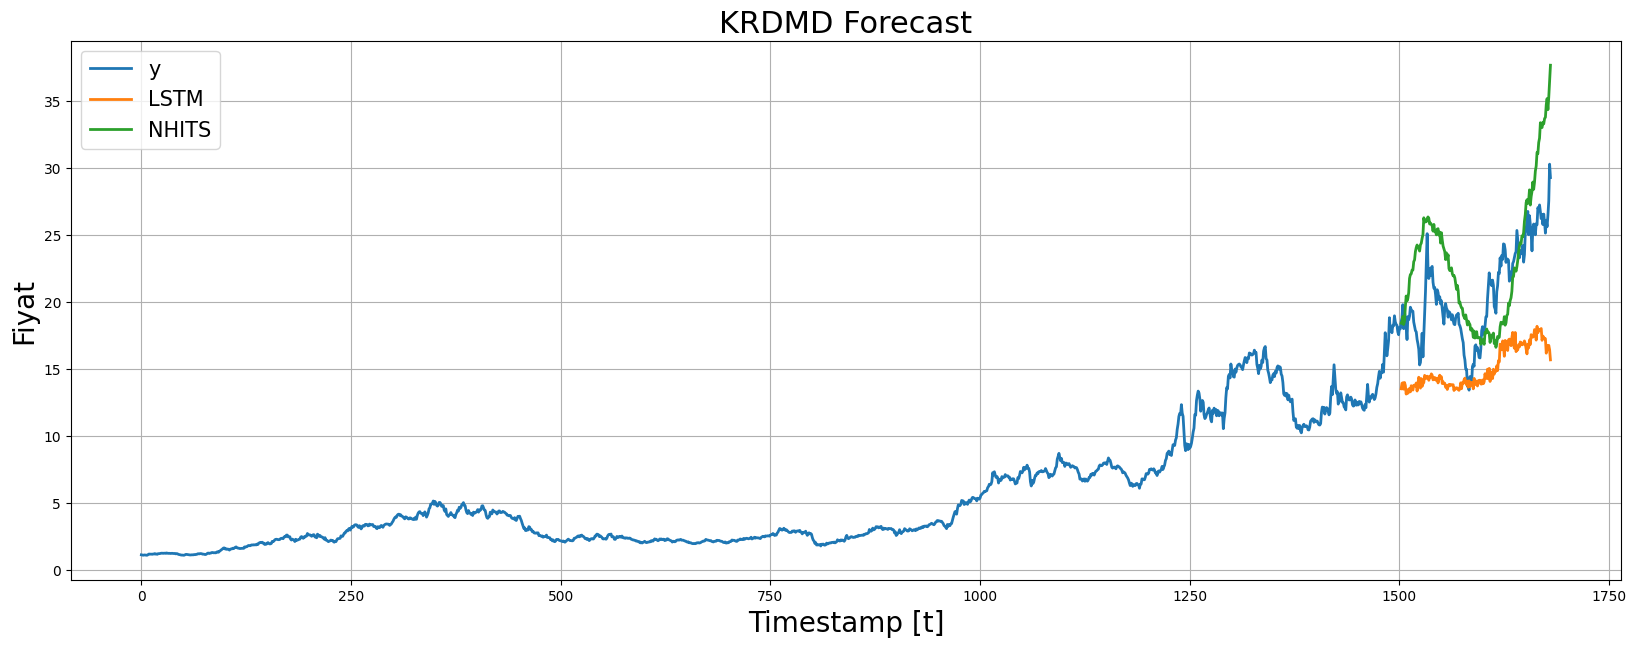

In [18]:
#Tarihler olmadan step olarak plot
import matplotlib.pyplot as plt
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))

plot_df = pd.concat([train, Y_hat_df_merged[['y','LSTM', 'NHITS']]]).set_index('ds').reset_index() # Concatenate the train and forecast dataframes
plot_df[['y','LSTM', 'NHITS']].plot(ax=ax, linewidth=2)

ax.set_title('KRDMD Forecast', fontsize=22)
ax.set_ylabel('Fiyat', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [19]:
plot_df

,ds,unique_id,y,LSTM,NHITS
0,2017-01-02,0.0,1.15,NaN,NaN
1,2017-01-03,0.0,1.14,NaN,NaN
2,2017-01-04,0.0,1.12,NaN,NaN
3,2017-01-05,0.0,1.13,NaN,NaN
4,2017-01-06,0.0,1.14,NaN,NaN
...,...,...,...,...,...
1676,NaT,NaN,25.60,16.740330,35.146698
1677,NaT,NaN,26.46,16.418509,34.322601
1678,NaT,NaN,27.52,16.757198,35.265266
1679,NaT,NaN,30.26,16.435673,36.414803


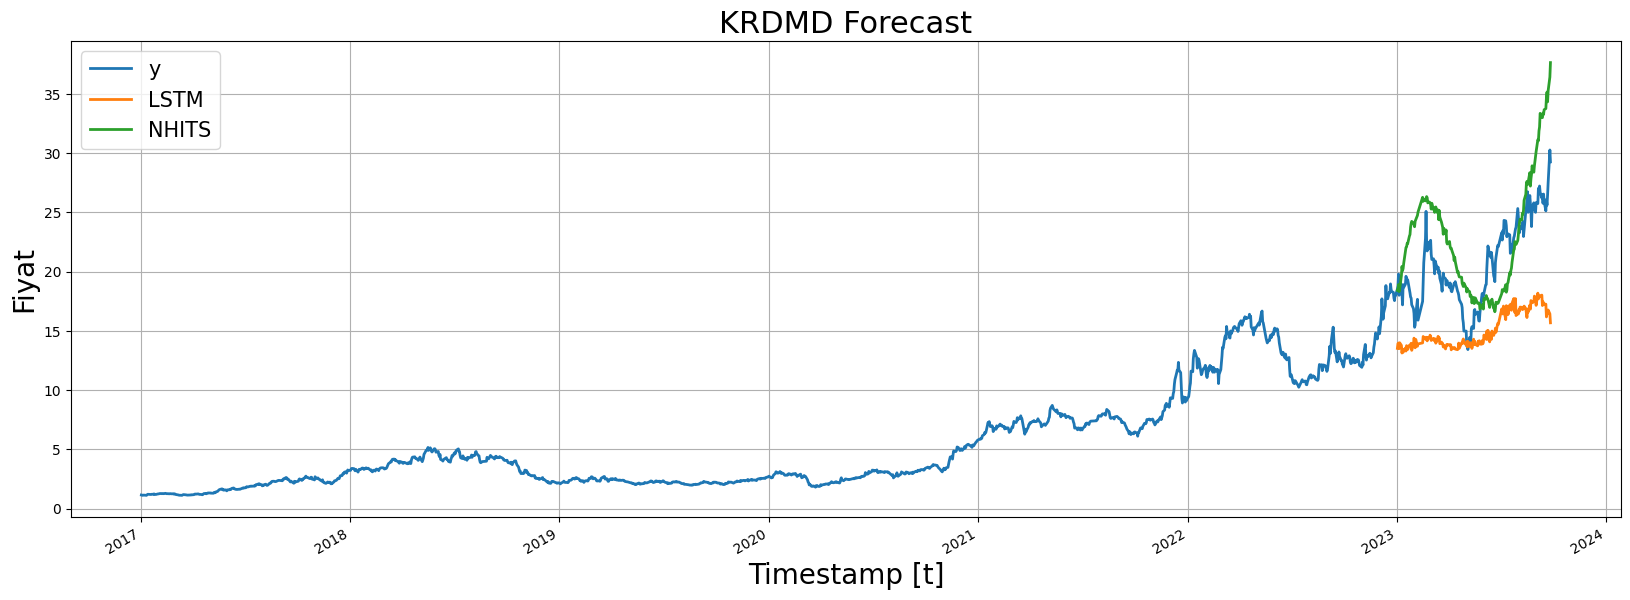

In [20]:
# Tarihler Index olarak verilmiş Plot
fig, ax = plt.subplots(1, 1, figsize = (20, 7))

plot_df = pd.concat([train.set_index('ds'), Y_hat_df_merged]) # Concatenate the train and forecast dataframes

plot_df[['y','LSTM', 'NHITS']].plot(ax=ax, linewidth=2)

ax.set_title('KRDMD Forecast', fontsize=22)
ax.set_ylabel('Fiyat', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()